In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#------------------------------
#cpu - gpu configuration
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
keras.backend.set_session(sess)
#------------------------------
#variables
height = 48
width = 48
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 64
epochs = 1000
#------------------------------
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("../images/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        #pixels = cv2.resize(pixels,(width,height))
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train -= x_train_mean
x_test -= x_test_mean
x_train /= x_train_std 
x_test /= x_test_std

x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], width, height, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

/home/connor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples


In [2]:
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(width, height, 1), data_format='channels_last'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same',))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(120, kernel_size=(5,5), activation='relu', padding='same',))
model.add(Flatten())

model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = val_gen.flow(x_test, y_test, batch_size=batch_size)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, verbose=1)

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=11, verbose=1, mode='auto')

checkpointer = ModelCheckpoint('../models/MODEL_A.h5', monitor='val_acc', verbose=1, save_best_only=True)

tensorboard = TensorBoard(log_dir='../logs/A')

steps_train = train_generator.n//train_generator.batch_size
steps_valid = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=steps_train, 
                                  validation_steps = steps_valid,
                                  epochs=epochs, 
                                  validation_data=valid_generator,
                                  callbacks=[early_stopper, checkpointer, tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 120)       48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1451604   
__________

448/448 [==============================] - 5s 11ms/step - loss: 0.0469 - acc: 0.9861 - val_loss: 3.9735 - val_acc: 0.5416

Epoch 00035: val_acc did not improve from 0.55234
Epoch 00035: early stopping


Text(0.5,1,'Accuracy Curves')

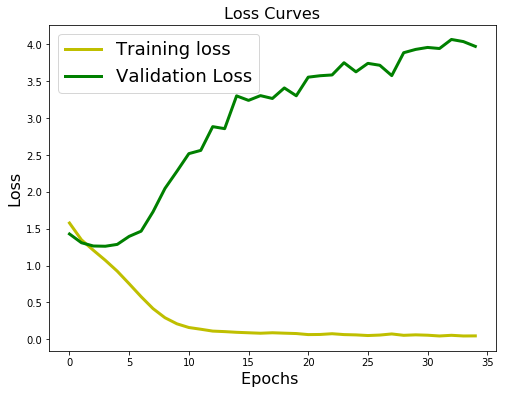

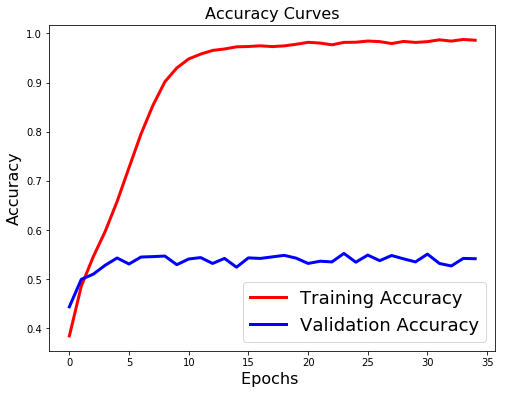

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'y',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# Accuracy curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)